In [1]:
from moist_konrad_Cshape import *
from rce2forcing import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [2]:
#This is the first test of coupling, I couple the RCE state of the atmosphere with 


results_file = open("results-Cshape-1.txt",'w')
temp_file = open("temp_Cshape-1.txt",'w')
water_file = open("water-Cshape-1.txt",'w')

In [3]:
cases = [1.]
initial_temperatures = [270.]
depths = [2.5]

initial_rh = [0.6]

RLS = 1/3

solar_multiplier = [0.975]
print(solar_multiplier)

land_atm_coupling = True
strong_coupling = True

albedo_sfc = 0.2

[0.975]


In [4]:
%%time

for k in range(len(solar_multiplier)):
    for rhi in range(len(initial_rh)):
        for de in range(len(depths)):
            for te in range(len(initial_temperatures)):
                print(depths[de],initial_temperatures[te],solar_multiplier[k],initial_rh[rhi])
                ###PARAMETERS OF THE TEST:

                #flux for efficiency computation:
                # 1: LH + SH
                # 2: Radiation surface
                # 3: Atmosphere radiation
                case = cases[0]
                depth_d = depths[de]
                ini_rh = initial_rh[rhi]


                #coupled surface-atmosphere: 
                #if true, surface fluxes and surface temperature change at each step, constant otherwise
                coupled = land_atm_coupling

                SH_f = 15.
                LH_f = 140.
                Ts_f = np.array([initial_temperatures[te]])
                print(Ts_f)

                #Strong coupling surface-atmosphere:
                #If true the atmosphere moist adiabat starts at surface temperature
                #If false find the atmopsheric moist adiabat that conserves energy
                strong = strong_coupling

                popke = True
                if popke == True:
                    solar = 510. * solar_multiplier[k]
                    angle = 47.9
                else:
                    solar = 480.* solar_multiplier[k]
                    angle = 42.05

                A = albedo_sfc

                ### INITIALIZATION
                E_imbalance = 0.

                plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
                atmosphere = konrad.atmosphere.Atmosphere(phlev)
                clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
                surface = konrad.surface.SlabOcean(
                    temperature=288,
                    heat_sink=0,
                    depth = depth_d,
                    albedo = 0.5)

                radiation = konrad.radiation.RRTMG(solar_constant=solar, zenith_angle = angle)

                ndays = 10000
                timestep = 0.5 #days
                nsteps = int(ndays/timestep)

                printcounter = 0
                status = 0

                tol = 1e-5

                ### RCPE COMPUTATION

                surface['temperature'] = Ts_f
                surface.albedo = A
                ini_T_atm = atmosphere['T'][0].copy()
                
                atmosphere['T'][0] = moist_adiabat(surface['temperature'],ini_T_atm,atmosphere)
                print(surface['temperature'],surface.albedo)

                conv_top = convective_top(atmosphere['T'][0],ini_T_atm,atmosphere['plev'])
                RH = manabe_rh(ini_rh,atmosphere['plev'], conv_top)
                atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
                T_atm_low = surface['temperature']

                print(surface['temperature'],surface.albedo)

                #### RCE FOR PRESENT-DAY CO2
                atmosphere['CO2'][0] = 348/1e6


                T_sfc_1 = [1e8]
                toa_1 = [1e8]
                for i in range(nsteps):
                    #surface fluxes
                    z = height(atmosphere['plev'],atmosphere['T'][0],
                               atmosphere['phlev'][0],surface['temperature'])


                    T_ini,vmr_ini = atmosphere['T'][0][0].copy(),atmosphere['H2O'][0,0].copy()

                    #compute the fluxes or input the forcing
                    if coupled == True:
                        LH = latent_heat(vmr_ini, T_ini,atmosphere['phlev'][0],RLS)
                        SH = sensible_heat(T_ini,surface['temperature'],atmosphere['phlev'][0],RLS)

                    else:
                        LH = LH_f
                        SH = SH_f


                    #convective adjustment of the armosphere
                    atmosphere,surface,radiation,net_rad_surface,atm_rad,sw_d,lw_d,\
                    T_atm_low,E_imbalance,prec_mass,prec_heating,\
                    RH,cold_point,prec_eff,water_content = RCPE_step_DSE(timestep,
                                                          atmosphere,surface,radiation,clearsky,
                                                          SH,LH,A,T_atm_low,
                                                          strong_coupling = strong,
                                                          constrain_RH = True,
                                                        Flux_case = case)



                    #update surface temperature with energetic fluxes (latent and radiative)
                    if coupled == True:
                        surface['temperature'] = surface['temperature'] + ((net_rad_surface - SH - LH)
                                               * seconds_day * timestep / surface.heat_capacity)

                    else:
                        surface['temperature'] = Ts_f


                    status += 1
                    if printcounter == 200:
                        print(status/2)
                    printcounter += 1

                    T_sfc_1.append(surface['temperature'])
                    toa_1.append(radiation['toa'].copy())
                    if abs(T_sfc_1[i]-T_sfc_1[i-1])<tol and abs(toa_1[i]-toa_1[i-1])<tol:
                        print(i)
                        break

                print('hehe')
                olr_rec = radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy()
                net_sw = radiation['sw_flxd'][0,-1].copy() - radiation['sw_flxu'][0,-1].copy()
                isr_rec = radiation['sw_flxd'][0,-1].copy()
                results_file.write(str(depth_d)+" "+str(case)+" "+str(Ts_f[0])
                                   +" "+str(surface['temperature'][0])+" "+str(T_ini)
                                   +" "+str(net_rad_surface)+" "+str(atm_rad)+" "+str(radiation['toa'][0])
                                   +" "+str(olr_rec)+" "+str(net_sw)+" "+str(isr_rec)
                                   +" "+str(E_imbalance[0])
                                   +" "+str(sw_d)+" "+str(lw_d)
                                   +" "+str(LH)+" "+str(SH[0])+" "+str(prec_eff[0])
                                   +" "+str(prec_mass[0])+" "+str(LH/Lv * seconds_day)
                                   +" "+str(RH[0])+" "+str(water_content[0])+" "+str(ini_rh)
                                   +" "+str(atmosphere['CO2'][0][0])
                                   +"\n")

                if de == 0 and te == 0:
                    np.savetxt(temp_file,atmosphere['T'][0].reshape(1, -1).copy())
                    np.savetxt(water_file,atmosphere['H2O'][0].reshape(1, -1).copy())

                P1 = prec_mass
                q1 = atmosphere['H2O'][0].copy()[0]
                RH1 = RH[0]
                
                print(RH1, radiation['toa'], E_imbalance, surface['temperature'])

2.5 270.0 0.975 0.6
[270.]
[270.] 0.2
[270.] 0.2
100.5
1296
hehe
0.6384205415705916 [0.0038669] [0.00337832] [288.1018036]
CPU times: user 39.3 s, sys: 136 ms, total: 39.4 s
Wall time: 39.4 s


In [5]:
lrad_rce = lw_d
srad_rce = sw_d
rain_rce = prec_mass[0]
rhum_rce = RH[0]
tair_rce = T_ini

write_forcing_files(lrad_rce, 
                    srad_rce, 
                    rain_rce, 
                    rhum_rce, 
                    tair_rce)

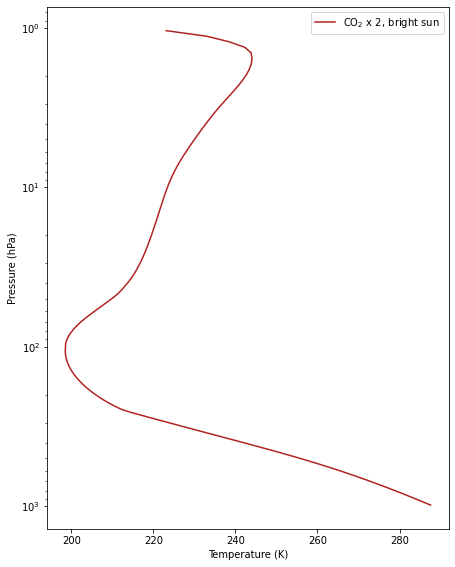

In [6]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))

p,ph = konrad.utils.get_pressure_grids(1000e2, 100, 128)

ax.plot(atmosphere['T'][0], p/100,
               alpha = 1, color = 'firebrick', lw = 1.5, label = 'CO$_2$ x 2, bright sun')


ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

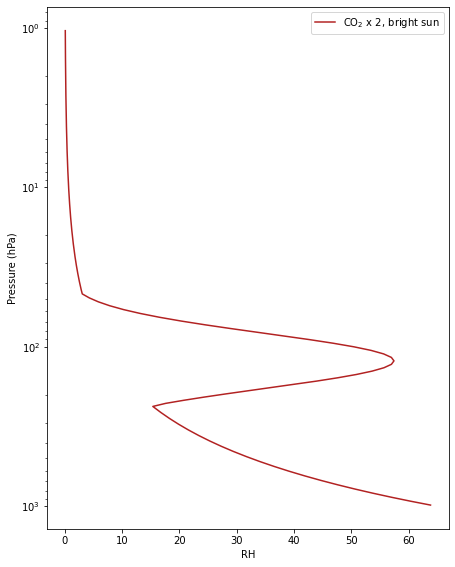

In [7]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))

p,ph = konrad.utils.get_pressure_grids(1000e2, 100, 128)

ax.plot(RH*100, p/100,
               alpha = 1, color = 'firebrick', lw = 1.5, label = 'CO$_2$ x 2, bright sun')


ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('RH')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

In [8]:
temp_file.close()
water_file.close()
results_file.close()
lambda_file.close()

NameError: name 'lambda_file' is not defined

In [ ]:
print(T_anom[200:,0])

In [ ]:
plt.scatter(T_anom[:,0], olr2[:], s = 2)
plt.show()
plt.scatter(T_anom[:,0], toa2[:,0], s = 5)
plt.show()

In [ ]:
lambda_1 = linregress( T_anom[500:,0], toa2[500:,0]).slope
lambda_2 = linregress( T_anom[500:,0], olr2[500:]).slope
print(lambda_1,lambda_2)

In [ ]:
print(radiation['sw_flxd'][0,-1])

In [ ]:
print(plev)
print(phlev)
print(z)